In this notebook I begin to explore my data and perform some simple data transformations. A brief discussion is avaiable in the Early Vectorizers notebook on some of the data transformation techniques (lemmatization & stemming).  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
from gensim.models import FastText
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD

from sklearn import svm, tree
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB

## Data Preview & Basic Cleanup

Simply opening the file and preview the basic data in the training set.

In [2]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df.head()

,label,text
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .


Do some basic cleanup of labels, not yet preprocessing the text at all.

In [3]:
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) )

df.head()

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


#### Are my labels balanced and evenly distributed? 

Or do I need to pay special care to my input data?

(array([1092., 2218., 1624., 2322., 1288.]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

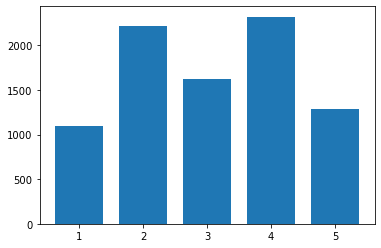

In [4]:
plt.hist(df['label'], bins=[1,2,3,4,5,6], align='left', rwidth=0.75)

A bit unbalanced, but not too much. Also a symetrical distrobution, not many extra positive or negative reviews; though theres slight more positive items. The lack of extreme imbalance implies I'm not going to be doing outlier detection algorithms, but the significant deviations in data quantity is probably going to result in some skewed learning from algorithms. We can always try class balancing to remedy it if it becomes an issue. 

#### How many reviews are more than a single sentence?

When getting to embedding models, can I treat each item as a single sentence? Based on the results, yes; nearly everything is a single sentence. Due to the overwhelming quantity of single sentances, rather than spend time parsing sentances I'll just treat everything as effectively one sentence. This will likely have extremely minor affects on algorithms like Word2Vec.

(array([8.457e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 8.500e+01,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

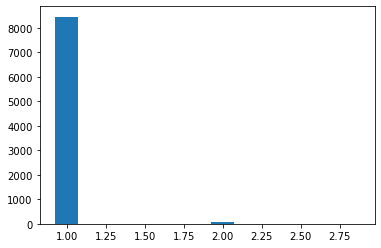

In [15]:
df['sentences'] = df['text'].apply(lambda x: len( sent_tokenize(x) ) )
plt.hist(df['sentences'], align='left', rwidth=0.75)

In [6]:
df2 = df.loc[df['sentences'] >= 2]
df2 = df2['text']
df2.head()

1      The gorgeously elaborate continuation of `` Th...
45     ... a sour little movie at its core ; an explo...
68     I walked away from this new version of E.T. ju...
199    As comedic spotlights go , Notorious C.H.O. hi...
537    E.T. works because its flabbergasting principa...
Name: text, dtype: object

## Preprocessing

Time to do a bit of preprocessing for different items. All items will be lowercase, punctuation & stop words stripped as well as some other basic preprocessing; plus one column thats stemmed and another lemmatized. We want to do these sorts of preprocessing because we do not want words that are effectively identical being treated differently. A capitolized word & uncapitolized version should not be treated as meaning different things. Similarily for plurality or other changes which lemmatization normalizes.

In [7]:
basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

df.head()

,label,text,sentences,basicProc,stemmed,lemmatized
0,4,The Rock is destined to be the 21st Century 's...,1,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,5,The gorgeously elaborate continuation of `` Th...,2,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,4,Singer/composer Bryan Adams contributes a slew...,1,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,3,You 'd think by now America would have had eno...,1,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,4,Yet the act is still charming here .,1,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


#### Word Count Distrobution

(array([ 726., 1370., 1754., 1430., 1430., 1028.,  439.,  249.,   95.,
          23.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

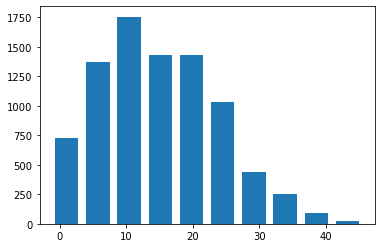

In [8]:
df['wordCount'] = df['lemmatized'].apply(lambda x: len(x.split()))
plt.hist(df['wordCount'], align='left', rwidth=0.75)

Unsurpisingly the distrobution is right skewed, though the tail is a bit shorter than expected still. Given that a relatively high percentage of reviews are short, I wonder how our predictions would get change if only juding on longer texts? Interesting how there are some very very short items. It would be potentially useful to delve into them and see if they're worth discarding alltogether. 